In [8]:
import random
import matplotlib.pyplot as plt
import math

In [9]:
POPULATION_SIZE = 100
P_CROSSOVER = 0.75
P_MUTATION = 0.10
MAX_EPOCHS = 25

DEFAULT_POLINOM = lambda x: x-(x**2)+0.2*(x**3)-0.01*(x**4)+0.00001*(x**5)
DEFAULT_LEFT_BORDER = -1
DEFAULT_RIGHT_BORDER = 12

DEFAULT_TOURNMENT_OPPONENTS = 3
DEFAULT_ALPHA = 0.3

# Штраф за концентрацию
DEFAULT_LAMBDA = -20
random.seed(42)

In [10]:
class Individual:
  def __init__(self, x: float) -> None:
    self.value = x
  def getValue(self) -> float:
    return self.value
  def __repr__(self) -> str:
    return str(self.value)

In [11]:
def createIndividual(x: float) -> Individual:
  return Individual(x)

def createPopulation(n: int, l: float, r: float):
    population= []

    interval_length = r - l
    step = interval_length / n
    current = l
    while(current < r):
      population.append(createIndividual(current))
      current += step
    return population

def mutation(individual: Individual) -> None:
  temp = individual.getValue()
  individual.value = temp + random.uniform(-0.2, 0.2)*temp

def crossFunc(first: Individual, second: Individual, alpha=DEFAULT_ALPHA) -> Individual:
  left_border = first.getValue() - alpha*(second.getValue() - first.getValue())
  right_border = second.getValue() + alpha*(second.getValue() - first.getValue())
  child = Individual(random.uniform(left_border, right_border))
  return child

def find_local_maxima(xy_list):
  local_maxima = []

  xy_list = sorted(xy_list, key=lambda x: x[0])

  for i in range(1, len(xy_list)-1):
    if xy_list[i][1] > xy_list[i-1][1] and xy_list[i][1] > xy_list[i+1][1]:
      local_maxima.append((xy_list[i][0], xy_list[i][1]))
          
  return local_maxima

In [12]:
class GenAlgorithm:
  def __init__(self, population_size=POPULATION_SIZE, p_crossover=P_CROSSOVER,\
               p_mutation=P_MUTATION, max_epochs=MAX_EPOCHS, function=DEFAULT_POLINOM, \
               left_border=DEFAULT_LEFT_BORDER, right_border=DEFAULT_RIGHT_BORDER) -> None:
    self.population_size = population_size
    self.p_crossover = p_crossover
    self.p_mutation = p_mutation
    self.max_epochs = max_epochs

    self.function = function
    self.left_border = left_border
    self.right_border = right_border

    self.history_x = []
    self.history_y = []
    self.history_max = []
    self.population = None

  def fitnessFunc(self, individual: Individual, lambda_param=DEFAULT_LAMBDA) -> float:
    value = self.function(individual.getValue())
    fine = sum(lambda_param*abs(ind.getValue() - individual.getValue()) / self.population_size for ind in self.population)
    return value - fine

  def tournmentSelection(self, population, n=DEFAULT_TOURNMENT_OPPONENTS):
    result = []
    for i in range(self.population_size):
      choice = random.sample(population, n)
      temp = []
      for index, ind in enumerate(choice):
        temp.append([self.fitnessFunc(ind), index])
      best_index = max(temp)[1]
      best_ind = choice[best_index]
      result.append(best_ind)
    return result
  
  def processHistoryMax(self):
    lengths = list(map(lambda x: len(x), self.history_max))
    average_length = lengths[(len(lengths)-1) // 2]

    temp_history_max = list(filter(lambda x: len(x) == average_length, self.history_max))
    average_maximals = [0 for _ in range(average_length)]

    for i in range(len(temp_history_max)):
      for j in range(average_length):
        average_maximals[j] += temp_history_max[i][j][1]
    
    for j in range(len(average_maximals)):
      average_maximals[j] = average_maximals[j] / len(temp_history_max)


    maximals = [-1*float('inf') for _ in range(average_length)]

    for i in range(len(temp_history_max)):
      for j in range(average_length):
        if math.fabs(average_maximals[j] - temp_history_max[i][j][1]) < 1e-1  or maximals[j] == -1*float('inf'):
          maximals[j] = max(maximals[j], temp_history_max[i][j][1])
    
    return maximals


  def fit(self):
    ans = -1*float('inf')
    self.population = createPopulation(self.population_size, self.left_border, self.right_border)

    self.history_x.append([ind.getValue() for ind in self.population])
    self.history_y.append([self.function(ind.getValue()) for ind in self.population])

    state = []
    i = 0
    while(i < self.max_epochs):

      best_ind = self.tournmentSelection(self.population)
      best_ind_shuffled = best_ind[:]
      random.shuffle(best_ind_shuffled)

      childs = []
      for j in range(self.population_size):
        if random.random() < self.p_crossover:
          childs.append(crossFunc(best_ind[j], best_ind_shuffled[j]))
        
      while(len(childs)) < self.population_size:
        childs.append(random.choice(self.population))

      self.population = childs

      for j in range(self.population_size):
        if random.random() < self.p_mutation:
          mutation(self.population[j])

      for j in range(self.population_size):
        if not(self.left_border <= self.population[j].getValue() <= self.right_border):
          self.population[j] = createPopulation(1, self.left_border, self.right_border)[0]

      self.history_max.append(find_local_maxima([(ind.getValue(), self.function(ind.getValue())) for ind in self.population]))

      self.history_x.append([ind.getValue() for ind in self.population])
      self.history_y.append([self.function(ind.getValue()) for ind in self.population])

      i += 1
  
    return self.processHistoryMax()

In [13]:
def getFunctionDots(n: int, l: float, r: float, func):
    interval_length = r - l
    step = interval_length / n
    current = l
    x = []
    y = []
    while(current < r):
      x.append(current)
      y.append(func(current))
      current += step
    return x, y

[0.2819239340626657, 11.54206089489845]


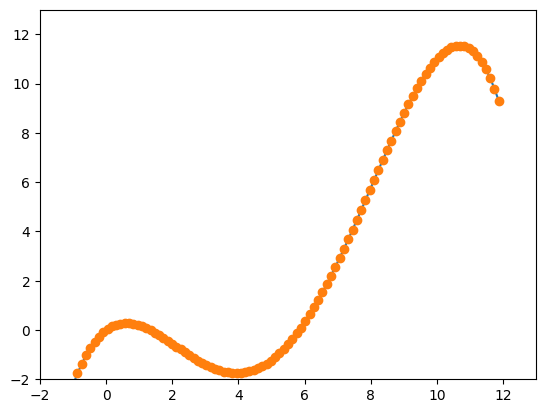

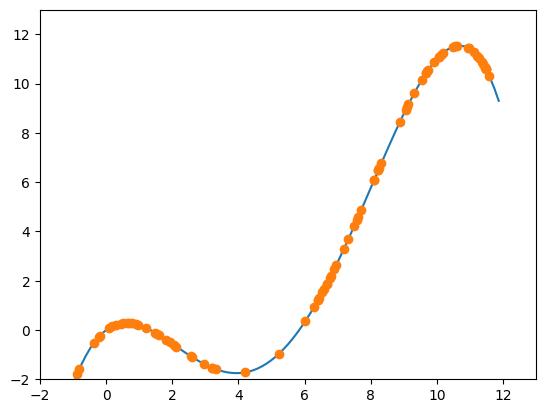

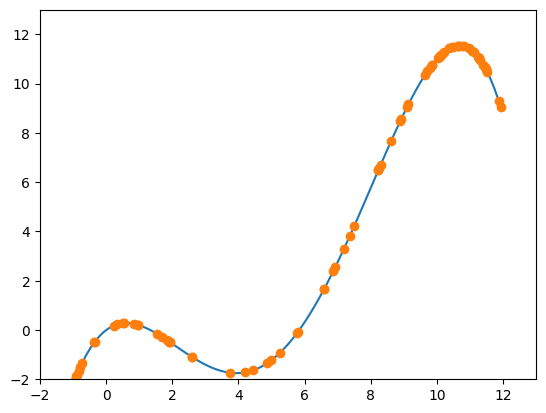

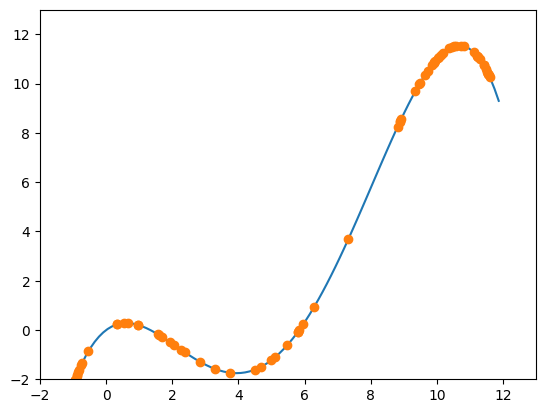

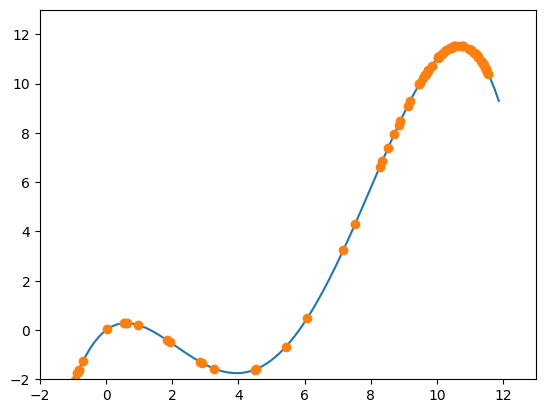

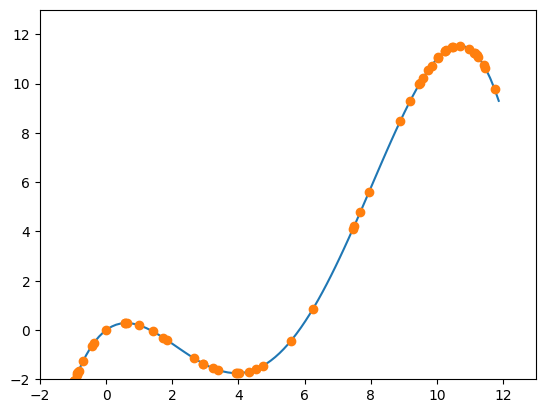

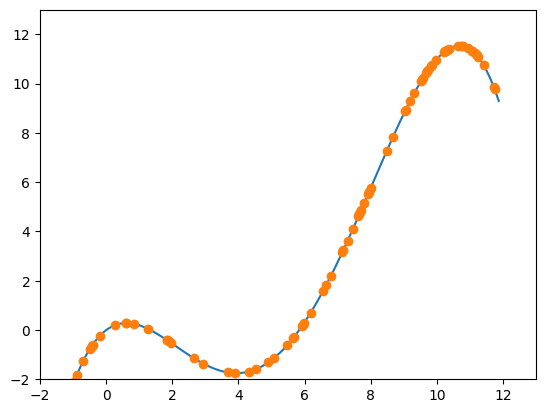

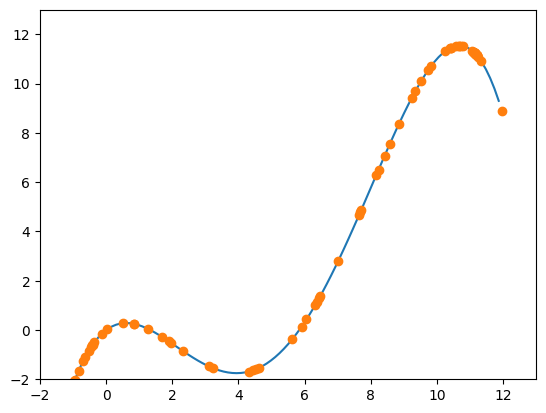

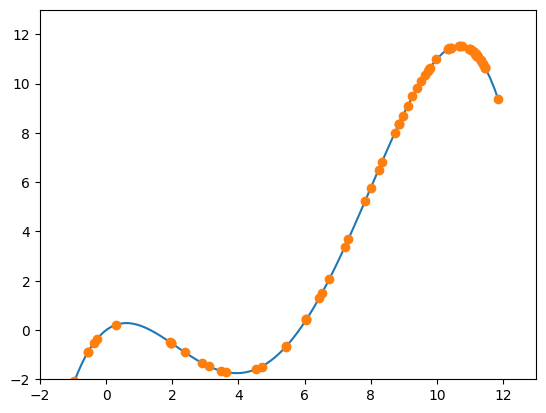

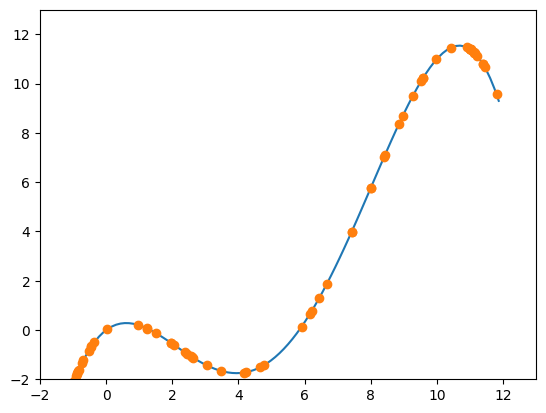

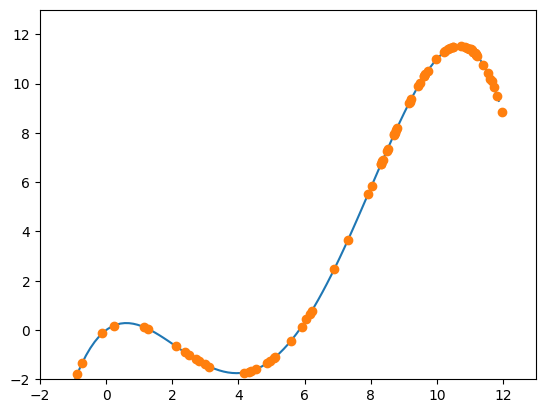

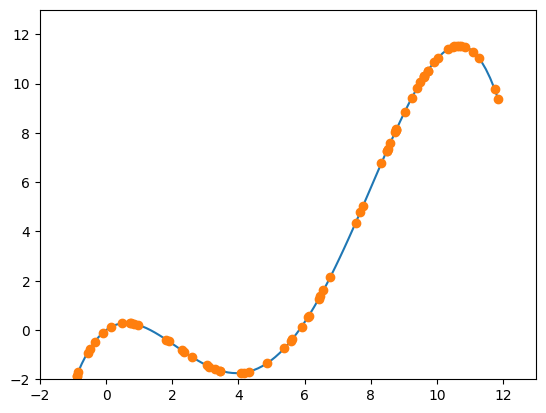

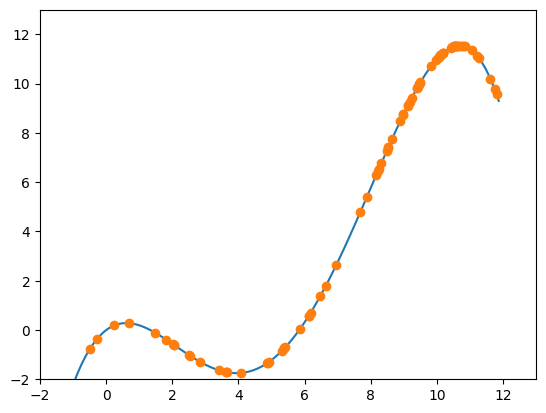

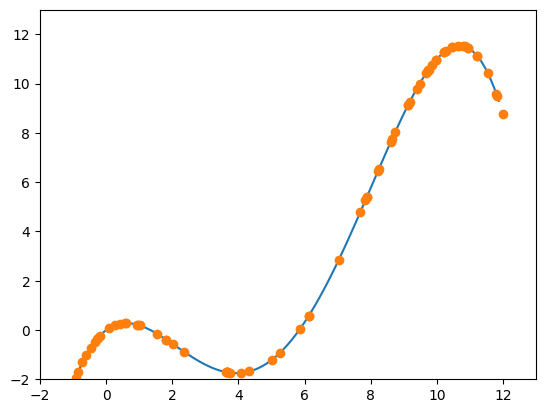

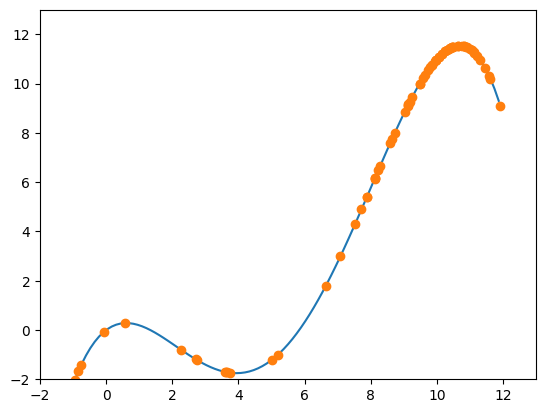

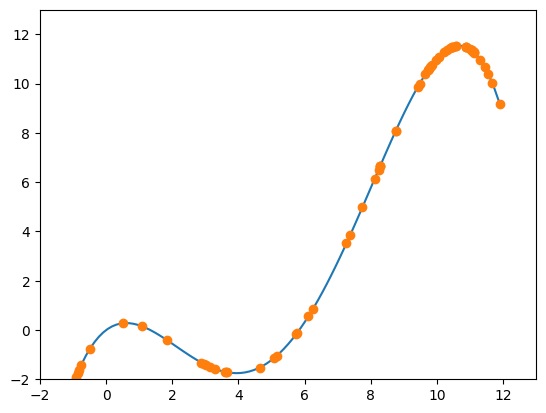

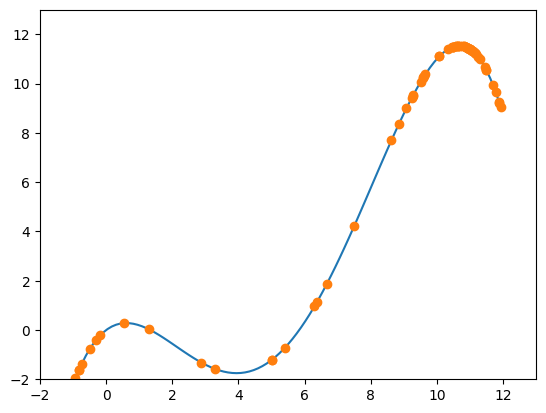

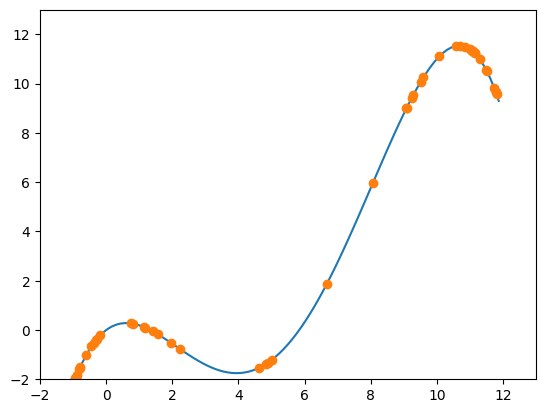

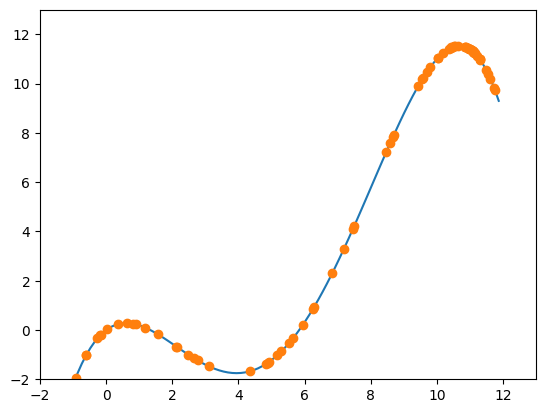

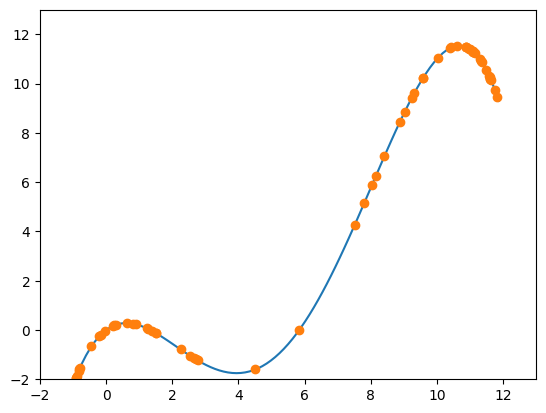

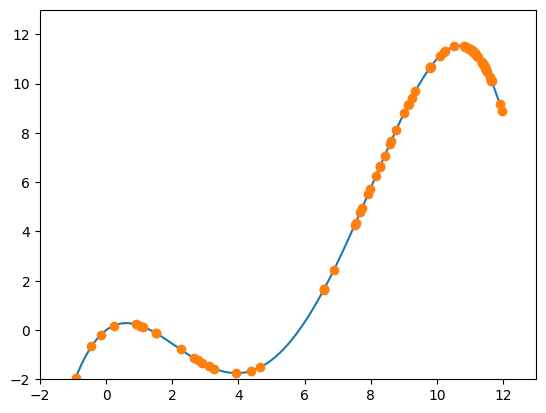

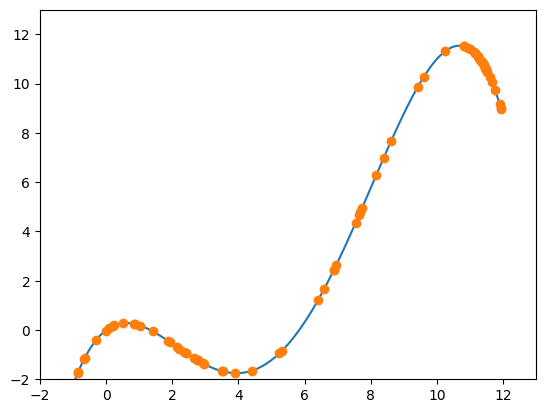

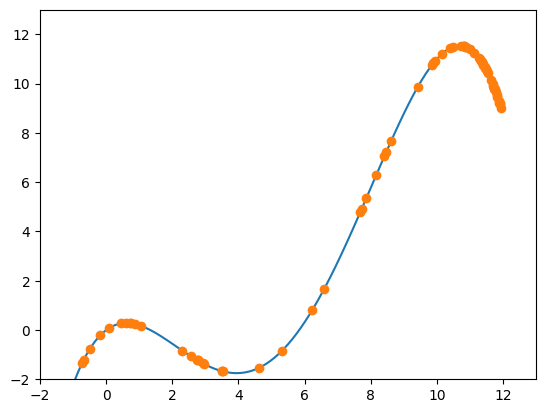

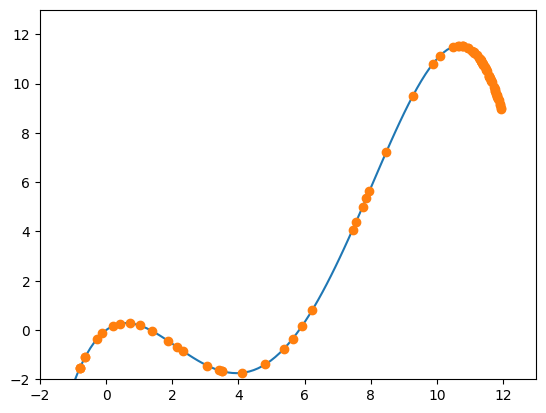

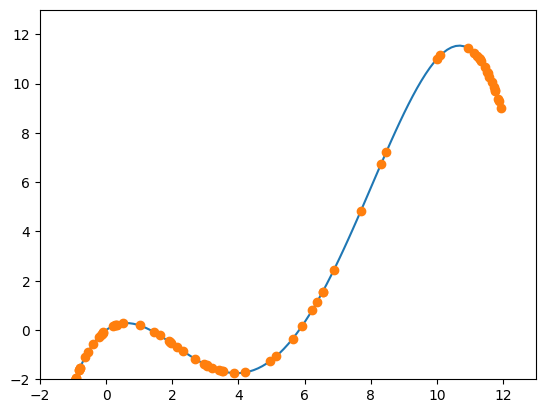

In [14]:
if __name__ == "__main__":

  A = GenAlgorithm()

  print(A.fit())

  for i in range(MAX_EPOCHS):

    x, y = getFunctionDots(100, DEFAULT_LEFT_BORDER, DEFAULT_RIGHT_BORDER, DEFAULT_POLINOM)
    plt.plot(x, y)
    plt.xlim(-2,13)
    plt.ylim(-2,13)
    plt.plot(A.history_x[i], A.history_y[i], 'o')
    plt.show()